# Demo: Multi-temporal Forest Type Segmentation

This notebook demonstrates all steps required for large-scale forest type mapping with machine learning. We will rely on satellite imagery from ESA's Sentinel-2 satellites as input data. The following notebook will focus mainly on the acquisition and inference part with the <a href="https://github.com/sentinel-hub/eo-learn">eo-learn library</a> and use on a pre-trained model from <a href="https://www.vision-impulse.com/">Vision Impulse GmbH</a>.  

## Getting Started

### 1. Overview

This notebook consists of three parts. First, we show how to access, acquire and pre-process Sentinel-2 imagery from <a href="https://www.sentinel-hub.com/">SentinelHub</a>. We then define a multi-temporal machine learning model (ConvLSTM) and provide you with pointers for the model training. Finally, we demonstrate how to perform inference with a trained model over a selected AOI using eo-learn.
* Part 1 - Data acquisition from Sentinel-Hub
* Part 2 - Model training with *eo-learn*
* Part 3 - Model inference with *eo-learn*

### 2. Packages and imports

Let's start by importing all required packages!

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import datetime
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon

from eolearn.core import (
    AddFeatureTask,
    EONode,
    EOPatch,
    EOTask,
    EOWorkflow,
    FeatureType,
    LoadTask,
    OverwritePermission,
    SaveTask,
)
from eolearn.io import SentinelHubInputTask
from sentinelhub import DataCollection, SHConfig, UtmZoneSplitter

### 3. Setting up access to Sentinel Hub

In order to run the example, you'll need a Sentinel Hub account. If you do not have one yet, you can create a free trial account at SentinelHub webpage. 

Once you have the account set up, please configure the SentinelHub package's configuration file following the configuration instructions. For Processing API requests, you need to obtain and set your OAuth client id and secret.

In [2]:
config = SHConfig()
config.sh_client_id = "40b7b8e1-414a-424f-ab00-4120f8df09d7"  # Provide your client id
config.sh_client_secret = "DpuSxgmYL36gCpoNNJFIIrOW2HGTGGkk"  # Provide your client secret
config.save()

# Part 1 - Data acqusition from SentinelHub

We start with selecting an area of interest that can be used for training or inference. In this notebook, we will load a polygon from the city of Kaiserslautern, Germany. 

A geographical polygon of Kaiserslautern was taken from the European Urban Atlas. The shape is available on the [Query Planet AWS S3 bucket](http://queryplanet.sentinel-hub.com/index.html).

### 1. Load the geometry of your area of interest

Let's first grab an AOI (Kaiserslautern, Germany) from the AWS Bucket.

In [3]:
!aws s3 ls s3://queryplanet.sentinel-hub.com/forest-map/

/usr/bin/sh: aws: command not found


In [4]:
!aws s3 cp s3://queryplanet.sentinel-hub.com/forest-map/DE044L1_KAISERSLAUTERN_UA2018_v012.gpkg ./forest-map/DE044L1_KAISERSLAUTERN_UA2018_v012.gpkg

/usr/bin/sh: aws: command not found


In [ ]:
#Another way to download info is to go to the gadm.org website and get .gpkg files of countries from there

In [3]:
geo_file = "gadm41_IDN.gpkg"

aoi_gdf = gpd.read_file(geo_file, layer="ADM_ADM_1")
aoi = aoi_gdf.geometry[0]
aoi_crs = aoi_gdf.crs


In [4]:
#This is view the layers within your downloaded .gpkg file
layers = gpd.io.file.fiona.listlayers(geo_file)
print(layers)

['ADM_ADM_0', 'ADM_ADM_1', 'ADM_ADM_2', 'ADM_ADM_3', 'ADM_ADM_4']


/home1/10028/llasell/.local/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


gadm41_IDN.gpkg


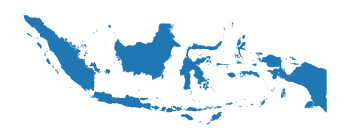

In [5]:
res = gpd.read_file(geo_file)
res.plot()
plt.axis("off")
print(geo_file)

### 2. Split the area of interest into small patches

We use **UtmZoneSplitter** class from sentinelhub to split the large area into smaller, manageable, non-overlapping rectangular tiles in a grid-style manner. This step is necessary for the model training and inference, as otherwise, the images become too large to load them to (GPU) memory. 

For simplicity in the next steps, we also store the geometry of the tile-grid into a new GeoDataFrame.

In [4]:
# Create a splitter to obtain a list of bboxes with 5km sides
bbox_splitter = UtmZoneSplitter([aoi], aoi_crs, 5000)

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list]
idxs = [info["index"] for info in info_list]
idxs_x = [info["index_x"] for info in info_list]
idxs_y = [info["index_y"] for info in info_list]

bbox_gdf = gpd.GeoDataFrame(
    {"index": idxs, "index_x": idxs_x, "index_y": idxs_y}, crs="EPSG:4326", geometry=geometry
).to_crs("EPSG:4326")

# Save to shapefile
bbox_gdf.to_file(os.path.join(".", "grid_kl_500x500.gpkg"), driver="GPKG")

/home1/10028/llasell/.local/lib/python3.7/site-packages/sentinelhub/constants.py:126: SHUserWarning: sentinelhub-py supports only WGS 84 coordinate reference system with coordinate order lng-lat. Given pyproj.CRS(4326) has coordinate order lat-lng. Be careful to use the correct order of coordinates.
  warnings.warn(message, category=SHUserWarning)


Let's visualize the non-overlapping extends of the patches over our area of interest.

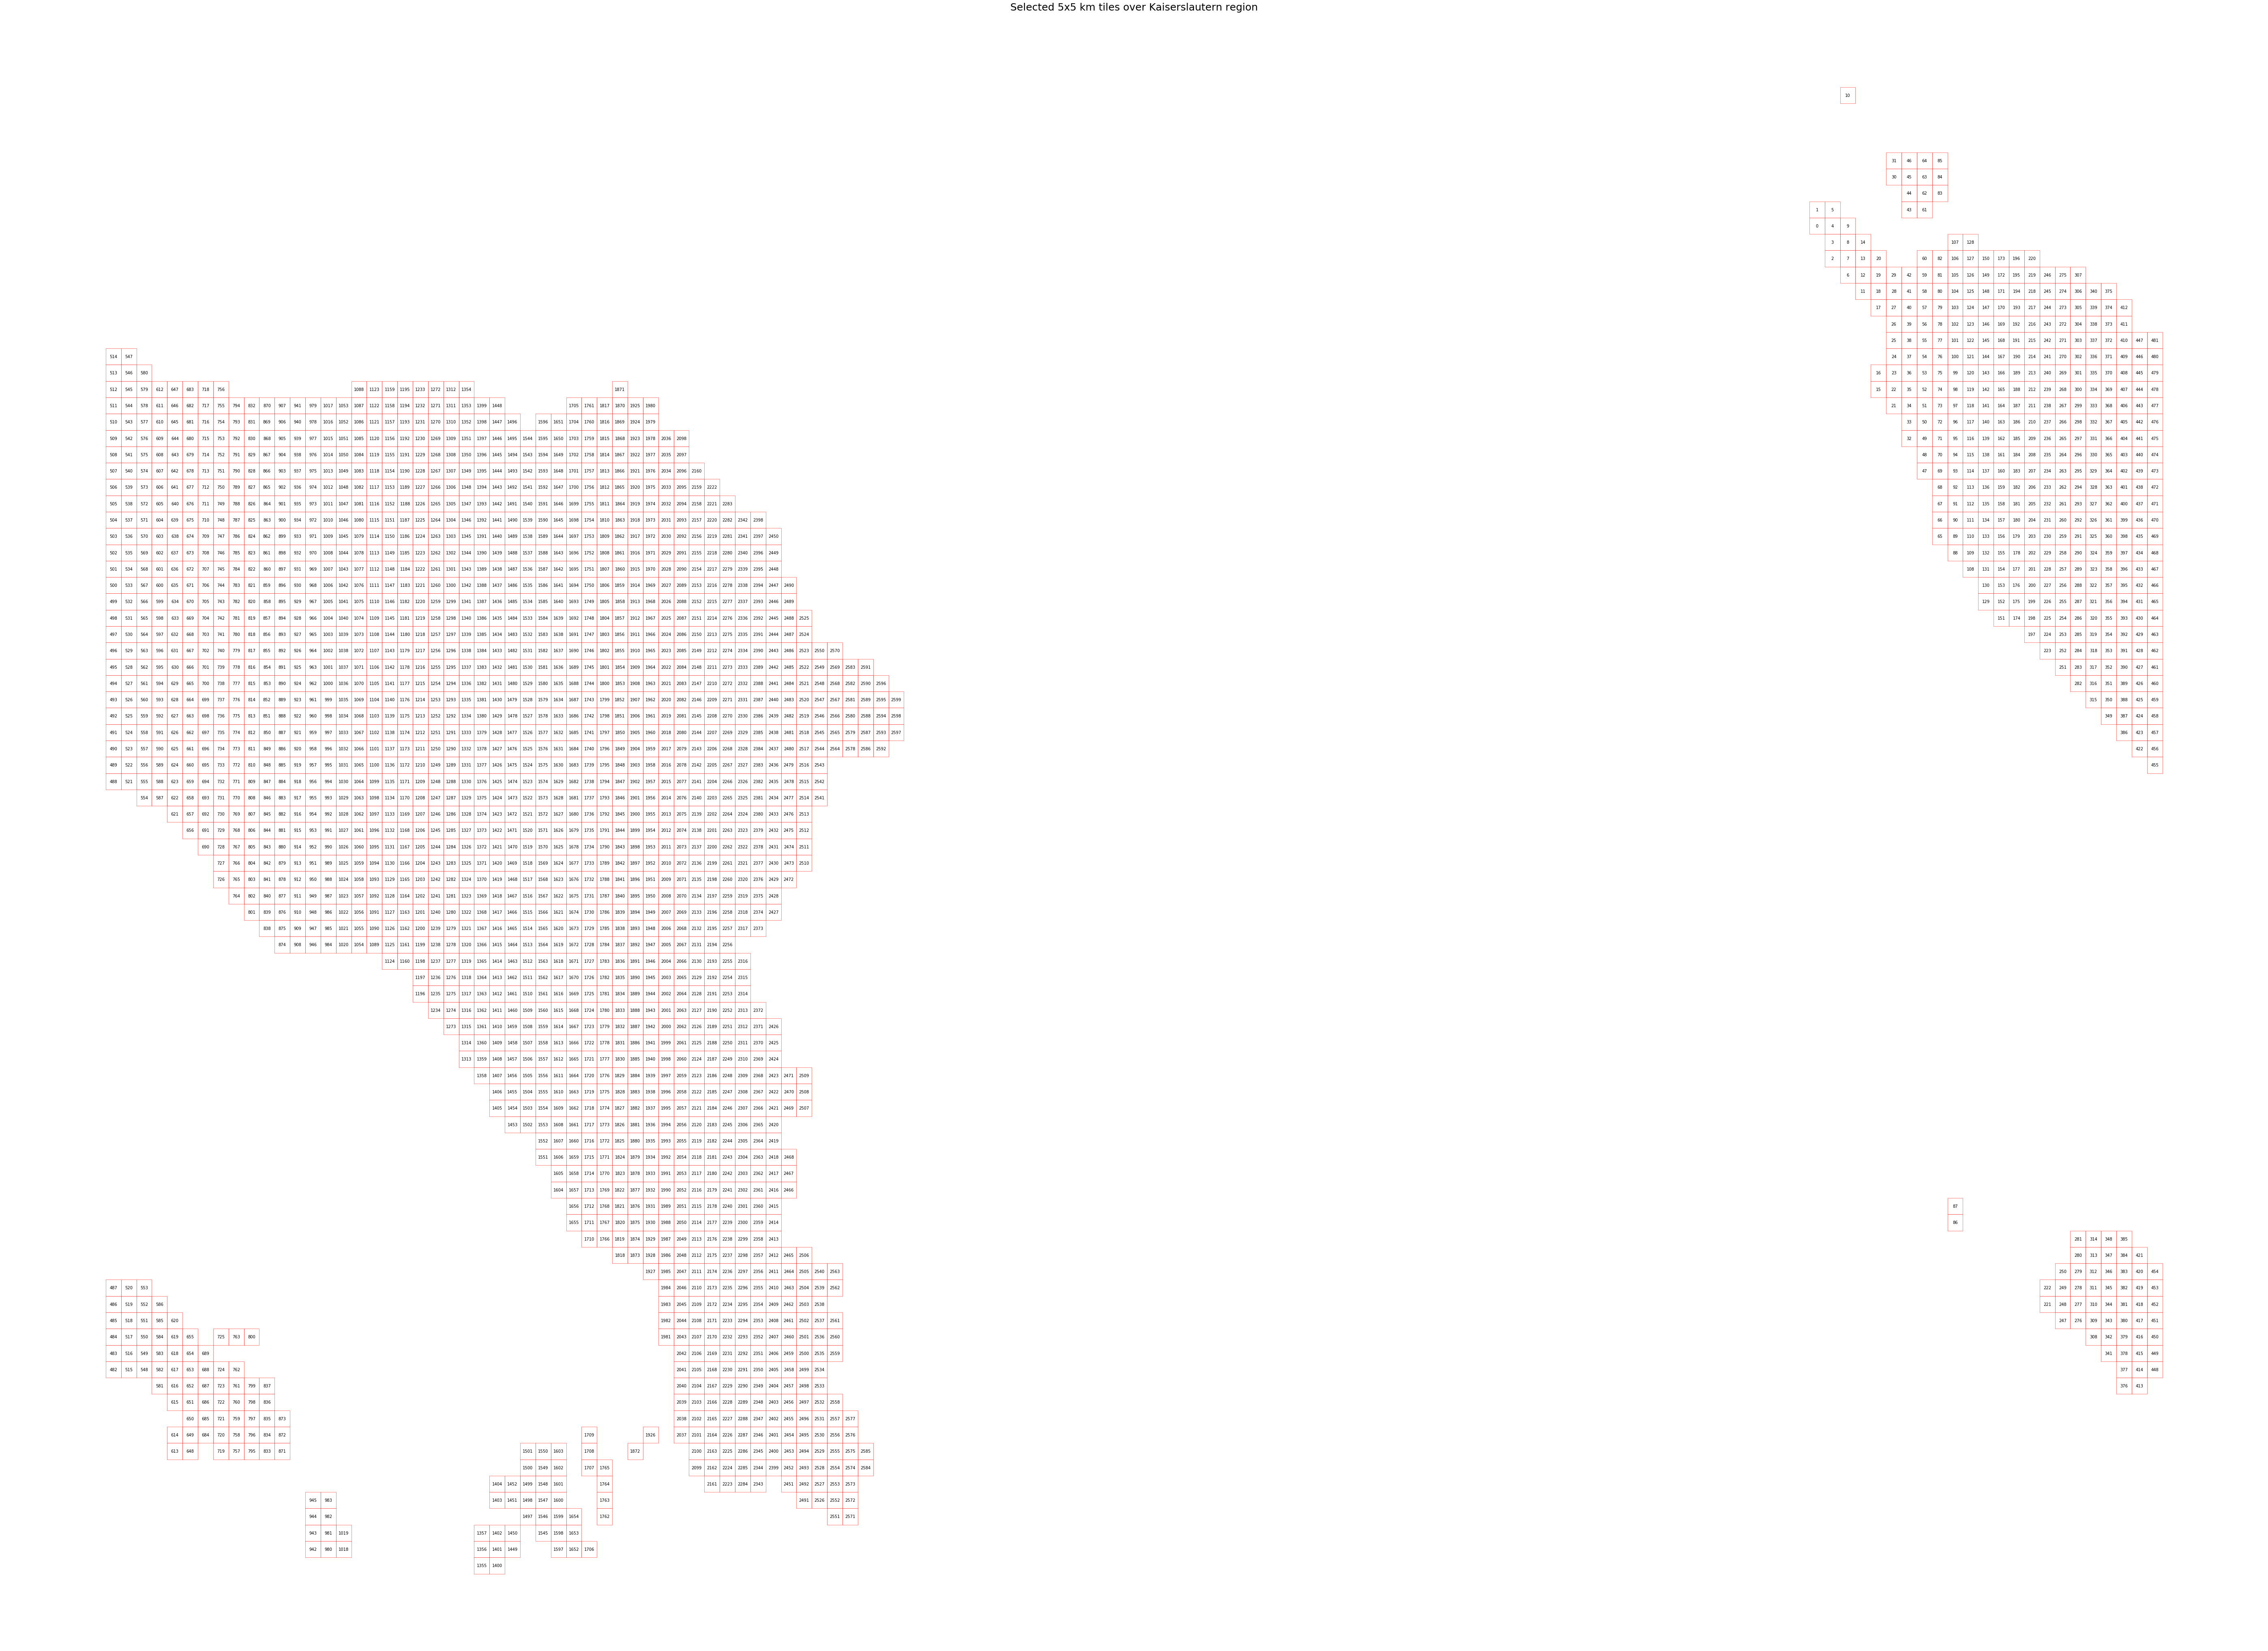

In [5]:
# Display bboxes over the Area of Interest
bbox_gdf = gpd.read_file(os.path.join(".", "grid_kl_500x500.gpkg"))
fig, ax = plt.subplots(figsize=(100,100))
ax.set_title("Selected 5x5 km tiles over Kaiserslautern region", fontsize=25)
bbox_gdf.plot(ax=ax, facecolor="w", edgecolor="r", alpha=0.5)

for bbox, info in zip(bbox_list, info_list):
    geo = bbox.geometry
    ax.text(geo.centroid.x, geo.centroid.y, info["index"], ha="center", va="center")
plt.axis("off");

### 3. Define a EO-Workflow for downloading the imagery 

We will rely on Sentinel-2 imagery (L2A) for this notebook and only use the 10-meter bands. We ignore images with a cloud cover higher than 20%.

In [56]:
download_task = SentinelHubInputTask(
    data_collection=DataCollection.SENTINEL2_L2A,
    bands_feature=(FeatureType.DATA, "BANDS"),
    resolution=10,
    time_difference=datetime.timedelta(minutes=120),
    maxcc=0.2,
    bands_dtype=np.uint16,
    bands=["B02", "B03", "B04", "B08"],
    config=config,
)

In [57]:
save_task = SaveTask("./EOPatches", overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

Next, we set up two simple **EONodes** for downloading and saving the data. The two tasks are chained by defining a sequential **EOWorkflow**. More information about the **EONodes** and **EOWorkflow** clases can be found <a href="https://eo-learn.readthedocs.io/en/latest/examples/core/CoreOverview.html#EONode-and-EOWorkflow">here</a>.

In [58]:
# Setup the nodes
download_node = EONode(download_task)
save_node = EONode(save_task, inputs=[download_node])

# Define the workflow
workflow = EOWorkflow([download_node, save_node])

Optional: In many cases, it can be useful to re-scale or convert the raw 16-bit imagery. The following example shows how to define your own **EOTask** for this processing task and integrate it directly into the downloading workflow.

Please note that the converted data is directly stored in each **EOPatch** and can be accessed under the key *SCALED_BANDS*.

In [59]:
class ScaleImageTask(EOTask):
    def __init__(self):
        super().__init__()

    def process_image(self, image):
        img = np.clip(image[:, :, :, :3], a_min=0, a_max=1500)
        img = img / 1500 * 255
        img = np.concatenate((img, image[:, :, :, 3][..., None]), axis=-1)
        img = img.astype(np.uint8)
        return img

    def execute(self, eopatch):
        image = eopatch[FeatureType.DATA]["BANDS"]
        scaled_image = self.process_image(image)
        eopatch[FeatureType.DATA]["SCALED_BANDS"] = scaled_image

        return eopatch


scale_image_task = ScaleImageTask()

download_node_with_scale = EONode(download_task)
scale_node = EONode(scale_image_task, inputs=[download_node_with_scale])
save_node_with_scale = EONode(save_task, inputs=[scale_node])

workflow_with_scale = EOWorkflow([download_node_with_scale, scale_node, save_node_with_scale])

### 4. Run the EO-Workflow and start downloading

Iterate over all tiled patches from step 2 and run the workflow. In this example, we restrict the time-interval to the summer months.

In [76]:
# Run the workflow over selected patches only instead of the complete AOI
TILE_IDS = [
   1176,
    860,
    764,
    861,
    1140,
    822
    
]

for idx in TILE_IDS:
    result = workflow.execute(
        {
            download_node: {"bbox": bbox_list[idx], "time_interval": ["2023-07-01", "2023-09-30"]},
            save_node: {"eopatch_folder": f"eopatch_{idx}"},
        }
    )

### 5. Let's visualize one EOPatch

Next, we are visualizing all time points of a single downloaded EO-Patch. 

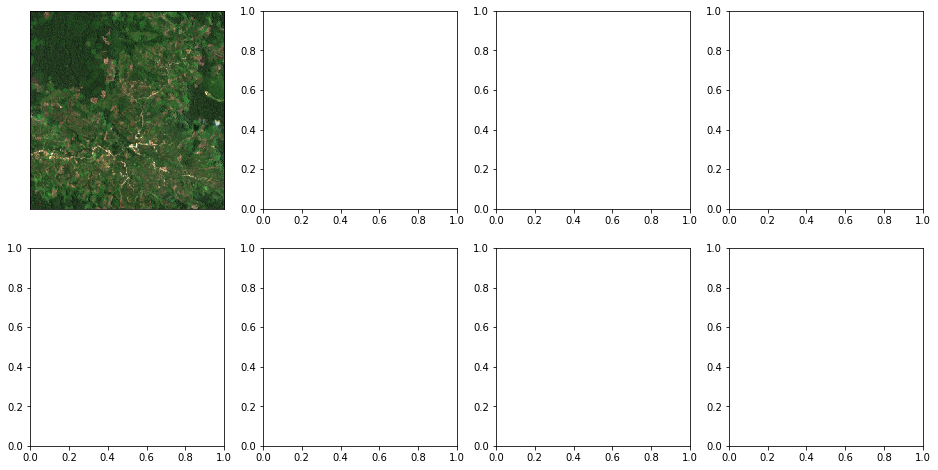

In [77]:
#Change the eopatch to one your visualizing
eopatch = EOPatch.load("./EOPatches/eopatch_1176")
scaled_image = eopatch[FeatureType.DATA]["BANDS"]

img = np.clip(scaled_image[:, :, :, :3], a_min=0, a_max=1500)
img = img / 1500 * 255
img = np.concatenate((img, scaled_image[:, :, :, 3][..., None]), axis=-1)

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for i in range(len(img)):
    img = img.astype(np.uint8)
    ax = axs[i // 4][i % 4]
    ax.imshow(img[i][..., [2, 1, 0]])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")

# Part 2 - Machine Learning model and training

The second part uses a machine learning model for the multi-temporal forest type classification. 
While countless machine learning models are available for this task (Random Forests, Support Vector Machines, Light Gradient Boosting), we rely on recent research results and use a model from the Deep Learning field. In particular, we use a Convolutional Long-Short-Term-Memory for this task since it allows us to learn spatio-temporal relationships.

### 1. Setup the environment
For this notebook, we use the deep learning framework <a href="https://pytorch.org/">PyTorch</a>. Let's import the required packages.

In [15]:
import torch
import torch.nn as nn

### 2. Define the model architecture

Next, we define a new **LSTMCell**, which uses a 2D Convolution as a cell operation. Next, we can define a simple version of a **ConvLSTM** network.

In [16]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()

        self.height, self.width = input_size
        self.i_dim = input_dim
        self.h_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(
            in_channels=self.i_dim + self.h_dim,
            out_channels=4 * self.h_dim,
            kernel_size=self.kernel_size,
            padding=self.padding,
            bias=self.bias,
        )

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.h_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next


class ConvLSTM(torch.nn.Module):
    def __init__(self, height, width, input_dim=13, hidden_dim=16, nclasses=4, kernel_size=(3, 3), bias=False):
        super(ConvLSTM, self).__init__()

        self.inconv = torch.nn.Conv3d(input_dim, hidden_dim, (1, 3, 3))

        self.cell = ConvLSTMCell(
            input_size=(height, width), input_dim=hidden_dim, hidden_dim=hidden_dim, kernel_size=kernel_size, bias=bias
        )

        self.final = torch.nn.Conv2d(hidden_dim, nclasses, (3, 3))

    def forward(self, x, hidden=None, state=None):
        x = x.permute(0, 4, 1, 2, 3)
        x = torch.nn.functional.pad(x, (1, 1, 1, 1), "constant", 0)
        x = self.inconv.forward(x)

        b, c, t, h, w = x.shape
        if hidden is None:
            hidden = torch.zeros((b, c, h, w))
        if state is None:
            state = torch.zeros((b, c, h, w))

        if torch.cuda.is_available():
            hidden = hidden.cuda()
            state = state.cuda()

        for iter in range(t):
            hidden, state = self.cell.forward(x[:, :, iter, :, :], (hidden, state))

        x = torch.nn.functional.pad(state, (1, 1, 1, 1), "constant", 0)
        x = self.final.forward(x)

        return x

### 3. Model training

Given the acquired satellite imagery and model definition, we can go over start training the model. The training does not require a particular geospatial context, as only sentinel images and rastered vector files are used. 

The extraction of rastering vector files and training can be done similarly as in this [notebook](https://github.com/sentinel-hub/eo-learn/blob/master/examples/land-cover-map/SI_LULC_pipeline.ipynb). Because of the same procedure, we do not repeat the same steps again in this notebook. If you are new to training models with PyTorch, we also recommend going over these [Tutorials](https://pytorch.org/tutorials/).

In [17]:
def convlstm(num_classes=3, in_channels=4):
    return ConvLSTM(
        512, 512, input_dim=in_channels, hidden_dim=24, nclasses=num_classes, kernel_size=(3, 3), bias=False
    )

# Part 3 - Model inference with a trained model

### 1. Define the inference workflow

We can now set up an inference workflow with the trained LSTM model and downloaded S2-imagery for the area of interest. 

First, we define a new **EOTask** which applies the trained **ConvLSTM** model on a single **EOPatch**.

In [18]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [19]:
class InferenceTask(EOTask):
    def __init__(self, model_file):
        self.model = convlstm(num_classes=4, in_channels=4).to(device)
        self.model.load_state_dict(torch.load(model_file, map_location=device))
        self.model.eval()
        self.add_output = AddFeatureTask((FeatureType.MASK_TIMELESS, "mask"))

    def execute(self, eopatch):
        image = eopatch[FeatureType.DATA]["BANDS"]
        image = np.array(image, dtype=np.float32)
        image /= 65535.0

        image = torch.Tensor(image).unsqueeze(0).to(device)

        output = self.model(image)
        output = torch.argmax(output, dim=1)
        output = output.squeeze(0).unsqueeze(-1).cpu().numpy()

        eopatch = self.add_output(eopatch, output)

        return eopatch

### 2. Load pre-trained model weights

Next, let's get the pre-trained model from the [Query Planet AWS S3 bucket](http://queryplanet.sentinel-hub.com/index.html).

In [ ]:
!aws s3 ls s3://queryplanet.sentinel-hub.com/forest-map/

In [ ]:
!aws s3 cp s3://queryplanet.sentinel-hub.com/forest-map/ ./forest-map/ --recursive

With the downloaded weights, we can instantiate the inference task.

In [20]:
model_file = "vi_forest_model_weights.pth"
inference_task = InferenceTask(model_file)

Next, we are using a SaveTask and creating an **EOWorkflow**. The workflow which loads an **EOPatch** applies the model and stores the result.

In [21]:
save_inference_task = SaveTask("./Predictions", overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [22]:
load_node = EONode(LoadTask("./EOPatches"))
inference_node = EONode(inference_task, inputs=[load_node])
save_inference_node = EONode(save_inference_task, inputs=[inference_node])

inference_workflow = EOWorkflow([load_node, inference_node, save_inference_node])

### 3. Run the inference workflow on a subarea

We select 16 tiles from our area of interest and run the workflow for a better overview.

In [78]:
TILE_IDS = [
1176,
    860,
    764,
    861,
    1140,
    822
]

In [79]:
for tile_id in TILE_IDS:
    inference_workflow.execute(
        {
            load_node: {"eopatch_folder": f"eopatch_{tile_id}"},
            save_inference_node: {"eopatch_folder": f"eopatch_{tile_id}"},
        }
    )

### 4. Visualize the model predictions for a subarea

Let's visualize the RGB channels for the S2 imagery for the selected subarea.

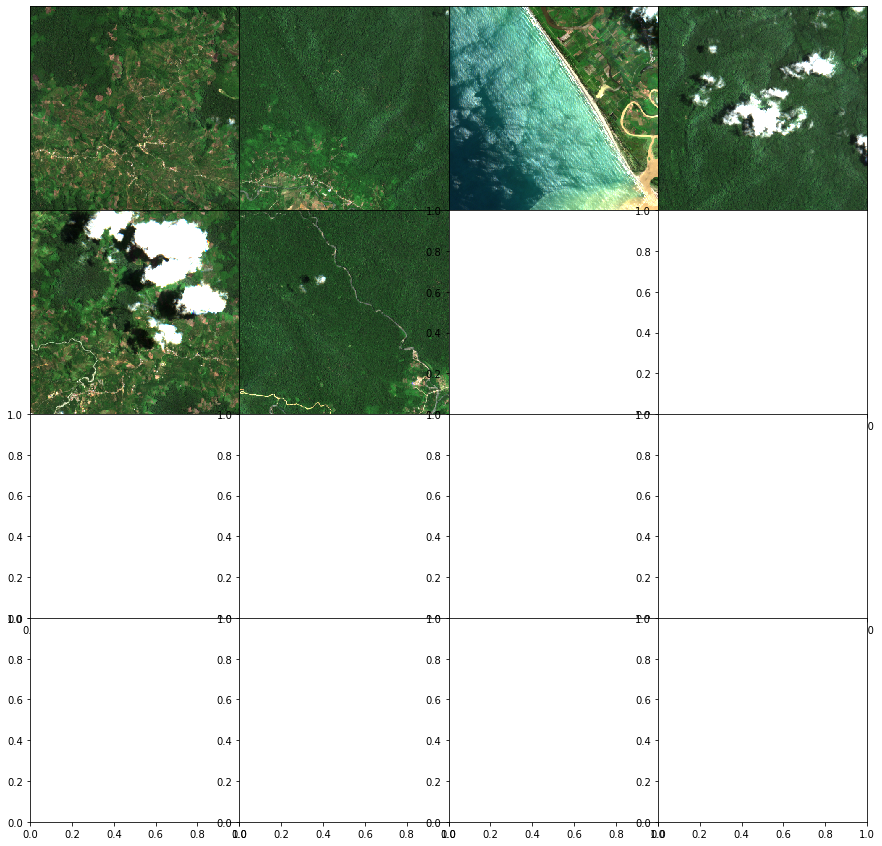

In [80]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

for i, tile_id in enumerate(TILE_IDS):
    eopatch = EOPatch.load(f"./EOPatches/eopatch_{tile_id}")
    scaled_image = eopatch[FeatureType.DATA]["BANDS"]
    img = np.clip(scaled_image[:, :, :, :3], a_min=0, a_max=1500)
    img = img / 1500 * 255
    img = np.concatenate((img, scaled_image[:, :, :, 3][..., None]), axis=-1)
    img = img.astype(np.uint8)

    ax = axs[i // 4][i % 4]
    ax.imshow(img[0][..., [2, 1, 0]])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")

fig.subplots_adjust(wspace=0, hspace=0)

We define color-codings for emphasizing the different class labels. 

In [81]:
COLOR_ENCODING = {
    0: [255, 255, 255],
    1: [70, 158, 74],
    2: [28, 92, 36],
    3: [255, 255, 255],
}


def labelVisualize(img, num_class=3):
    img = img[:, :, 0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i, :] = COLOR_ENCODING[i]
    return img_out.astype(np.uint8)

Next, we visualize the selected tiles' predictions. We show how the model can be used to create a forest/tree layer.

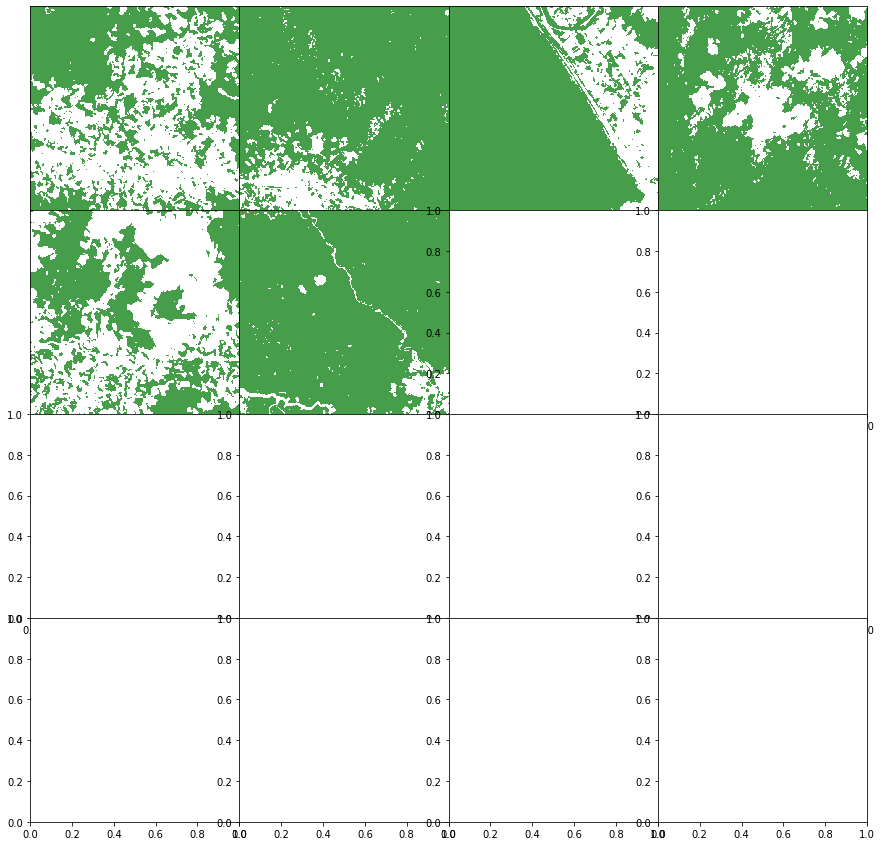

In [82]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
for i, tile_id in enumerate(TILE_IDS):
    inferenced_eopatch = EOPatch.load(f"./Predictions/eopatch_{tile_id}")
    output = inferenced_eopatch[FeatureType.MASK_TIMELESS]["mask"].squeeze(-1)
    output[output == 2] = 1
    output = labelVisualize(output)
    ax = axs[i // 4][i % 4]
    ax.imshow(output)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")

fig.subplots_adjust(wspace=0, hspace=0)

At the same time, we can also visualize the dominant leaf types. 

The maps show the **coniferous trees** class in light green and **broadleaf trees** class in dark green.

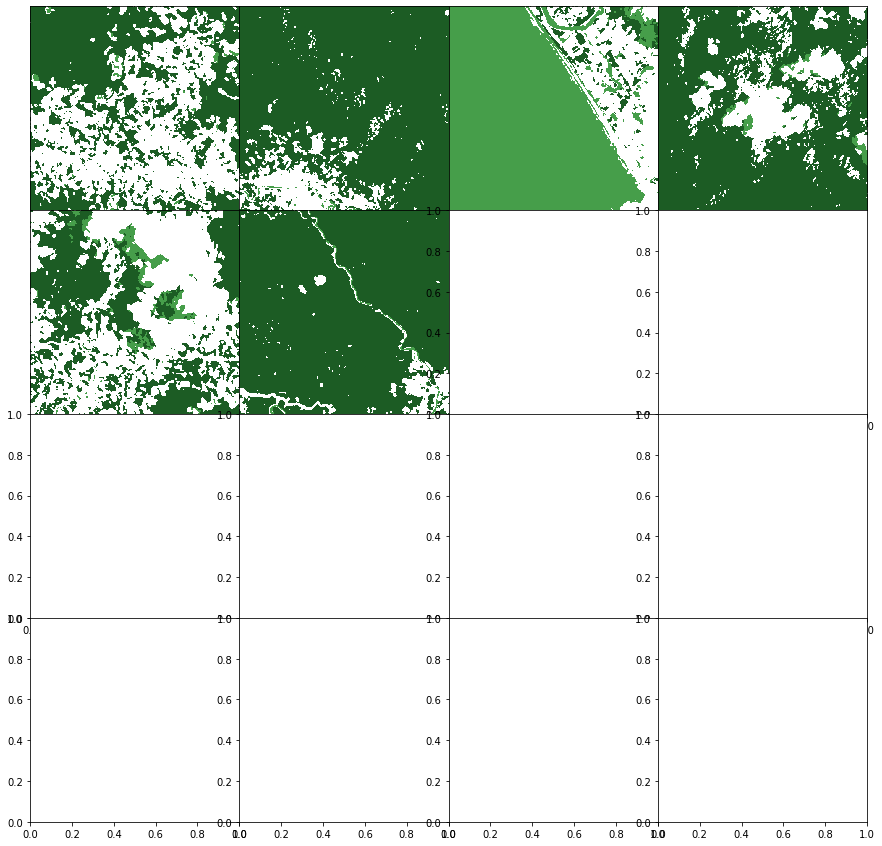

In [83]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
for i, tile_id in enumerate(TILE_IDS):
    inferenced_eopatch = EOPatch.load(f"./Predictions/eopatch_{tile_id}")
    output = inferenced_eopatch[FeatureType.MASK_TIMELESS]["mask"].squeeze(-1)
    output = labelVisualize(output)
    ax = axs[i // 4][i % 4]
    ax.imshow(output)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")

fig.subplots_adjust(wspace=0, hspace=0)

We can also select individual patches to visualize the input imagery and model predictions in more detail.

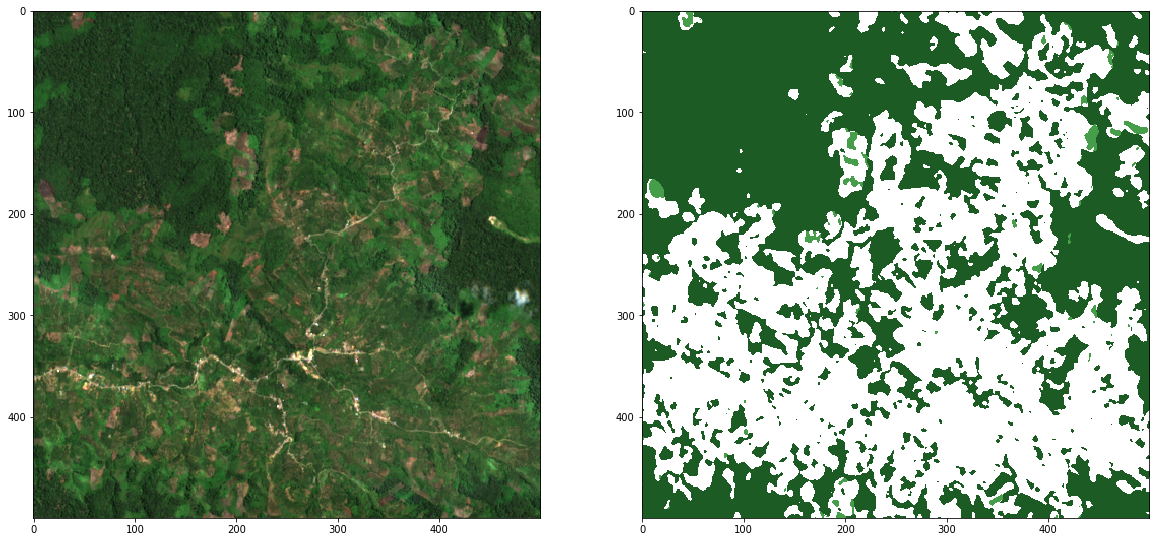

In [86]:
eopatch = EOPatch.load("./EOPatches/eopatch_1176")
scaled_image = eopatch[FeatureType.DATA]["BANDS"]
img = np.clip(scaled_image[:, :, :, :3], a_min=0, a_max=1500)
img = img / 1500 * 255
img = np.concatenate((img, scaled_image[:, :, :, 3][..., None]), axis=-1)
img = img.astype(np.uint8)

inferenced_eopatch = EOPatch.load("./Predictions/eopatch_1176")
output = inferenced_eopatch[FeatureType.MASK_TIMELESS]["mask"].squeeze(-1)
output = labelVisualize(output)

fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(img[0][..., [2, 1, 0]])
ax[1].imshow(output);

## 4. Running the model on a large-scale

Finally, we applied the trained model on a larger scale over the surface of the EEA39 area. The following picture shows an overview of the extracted forest types over the country Germany for the year 2020.

![alt text](figs/map_germany.png "Forest Type Map")

## 5. Large-scale forest mapping demonstration

If you are more interested in the final results, we also provide an up-to-date map for 2020. Our created forest type map can be accessed under <a href="https://app.vision-impulse.com/forestmapper/">Vision Impulse Forest Demo</a>.


For more information, please do not hesitate to contact us under info[at]vision-impulse.com.